In [57]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np

from src import config
import src.optimization_utils as ou


### 1. Data Cleaning & Preprocessing

In [58]:
pd.set_option('display.max_columns', None)

# Load cleaned data from config path
df = pd.read_csv(config.DATA_PROCESSED)
df.columns = df.columns.astype(str).str.replace("\n"," ").str.replace(r"\s+"," ", regex=True).str.strip()

print(f"Loaded {len(df)} patients, {df.shape[1]} columns")
print(f"Data path: {config.DATA_PROCESSED}")


Loaded 271 patients, 109 columns
Data path: /Users/jennkim/Documents/capstone/code/Data-Science-Capstone/data/processed/cleaned_for_modeling.csv


In [59]:
#change data type to numeric for calculation
df[["gap_score_preop", "gap_score_postop"]]\
    = df[["gap_score_preop", "gap_score_postop"]]\
        .apply(pd.to_numeric, errors="coerce").astype("Int64")
df[["ODI_preop", "ODI_12mo"]]\
    = df[["ODI_preop", "ODI_12mo"]]\
        .apply(pd.to_numeric, errors="coerce").astype(float)

### 1.1 Define input variables

In [60]:
#patient preop fixed parameters
PATIENT_FIXED_COLS = config.PATIENT_FIXED_COLS
FEATURES = config.DELTA_MODEL_FEATURES.copy()

print("== FEATURES ==")
for i in FEATURES:
    print(i)

FEATURES.remove("gap_score_preop")
FEATURES.remove("gap_category")

FEATURES_CAT = [c for c in FEATURES if df[c].dtype == "object"]
print("\n == Categorical Features ==")
for i in FEATURES_CAT:
    print(i)

FEATURES_NUM = [c for c in FEATURES if df[c].dtype != "object"]
print("\n == Numerical Features (includes binary) ==")
for i in FEATURES_NUM:
    print(i)


== FEATURES ==
age
sex
bmi
C7CSVL_preop
SVA_preop
T4PA_preop
L1PA_preop
LL_preop
L4S1_preop
PT_preop
PI_preop
SS_preop
cobb_main_curve_preop
FC_preop
tscore_femneck_preop
HU_UIV_preop
HU_UIVplus1_preop
HU_UIVplus2_preop
gap_category
gap_score_preop
global_tilt_preop
CCI
ASA_CLASS
ODI_preop
UIV_implant
num_levels_cat
num_interbody_fusion_levels
ALIF
XLIF
TLIF
num_rods
num_pelvic_screws
osteotomy

 == Categorical Features ==
sex
ASA_CLASS
UIV_implant
num_levels_cat

 == Numerical Features (includes binary) ==
age
bmi
C7CSVL_preop
SVA_preop
T4PA_preop
L1PA_preop
LL_preop
L4S1_preop
PT_preop
PI_preop
SS_preop
cobb_main_curve_preop
FC_preop
tscore_femneck_preop
HU_UIV_preop
HU_UIVplus1_preop
HU_UIVplus2_preop
global_tilt_preop
CCI
ODI_preop
num_interbody_fusion_levels
ALIF
XLIF
TLIF
num_rods
num_pelvic_screws
osteotomy


### 2. Build Models

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict, cross_val_score, KFold, LeaveOneOut
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, PredictionErrorDisplay, make_scorer

from xgboost import XGBRegressor

### 2.1 Set up for model building and hyperparameter tuning

In [62]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

ridge_numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
    )

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),  
           ("encoder", OneHotEncoder(handle_unknown="ignore")) 
        ]
    )

# Transform heterogeneous data types
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, FEATURES_NUM),
        ("cat", categorical_transformer, FEATURES_CAT),
        ]
    )
ridge_preprocessor = ColumnTransformer(
    transformers=[
        ("num", ridge_numeric_transformer, FEATURES_NUM),
        ("cat", categorical_transformer, FEATURES_CAT),
        ]
    )


#hyperparameter tuning parameters
param_distributions = {"regressor__n_estimators": [200, 300, 400, 500, 600],
               "regressor__max_depth": [ 8, 12, 15, 20, None],
               "regressor__min_samples_split" : [2, 5, 10, 15, 20],
               "regressor__min_samples_leaf": [2, 4, 6, 8, 10], 
               "regressor__max_features": ["sqrt", "log2"]}

ridge_param_distributions = {"regressor__alpha": [0.01, 0.1, 1, 10, 100, 1000],
                             "regressor__solver": ["auto", "svd", "cholesky"]}


In [90]:
def train_rf_model(X_train, X_test, y_train, y_test):
    "Builds and fits a Random Forest model using a pipeline"

    pipeline = Pipeline([
        ("preprocessor", clone(preprocessor)), 
        ("regressor", RandomForestRegressor(n_estimators=300, 
                                            random_state=42,
                                            max_depth=8,
                                            min_samples_leaf=5,
                                            oob_score=True))
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    oob = pipeline.named_steps["regressor"].oob_score_
    
    print("-- Random Forest Model --")

    print(f"R² score: {round(r2,3)}")
    print(f"RMSE: {round(rmse,3)}")
    print(f"MAE: {round(mae, 3)}")
    print(f"OOB score: {round(oob,3)}")

    return pipeline, y_pred
                   
def randomized_search_cv(pipeline, param_distributions, X_train,y_train, X_test,y_test):
    "Performs randomized search cross-validation on a model"
    
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        cv=5,
        scoring="r2",
        n_jobs=-1
    )
    #fit the model
    random_search.fit(X_train,y_train)

    #best paramaters
    best_parameters = random_search.best_params_
    best_cv_R2 = random_search.best_score_
    best_model = random_search.best_estimator_

    #prediction
    y_pred = random_search.predict(X_test)

    #metrics
    test_R2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 

    print("--Randomized search results--")
    print("Best parameters:")
    for k,v in best_parameters.items():
        print(f"  {k}: {v}")
    print(f"Best CV R2: {round(best_cv_R2,3)}")
    print(f"Test R2: {round(test_R2,3)}")
    print(f"Test RMSE: {round(test_rmse,3)}")

    return best_model, y_pred

def train_xgboost_model(X_train, X_test, y_train, y_test):
    "Builds and fits an XGBoost model using a pipeline"

    pipeline = Pipeline([
        ("preprocessor", clone(preprocessor)),
        ("regressor", XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ))
        ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print("-- XGBOOST Model --")

    print(f"R² score: {round(r2,3)}")
    print(f"RMSE: {round(rmse,3)}")
    print(f"MAE: {round(mae, 3)}")
  
    return pipeline, y_pred

def train_ridge_model(X_train, X_test, y_train, y_test, alpha=1):
    "Builds and fits a Ridge Regression model within a pipeline"

    pipeline = Pipeline([
        ("preprocessor", clone(ridge_preprocessor)),
        ("regressor", Ridge(alpha=alpha))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print("-- Ridge Regression Model --")

    print(f"R² score: {round(r2,3)}")
    print(f"RMSE: {round(rmse,3)}")
    print(f"MAE: {round(mae, 3)}")

    return pipeline, y_pred     

#new pipeline for model comparison
def compare_models(X, y, cv=5):
    models = {
        "RF": Pipeline([("preprocessor", clone(preprocessor)), 
                        ("regressor", RandomForestRegressor(n_estimators=300, 
                                                            random_state=42, 
                                                            max_depth=8, 
                                                            min_samples_leaf=5))]),
        "XGBoost": Pipeline([("preprocessor", clone(preprocessor)), 
                             ("regressor", XGBRegressor(n_estimators=300, 
                                                        learning_rate=0.05, 
                                                        subsample=0.8, 
                                                        colsample_bytree=0.8, 
                                                        random_state=42))]),
        "Ridge": Pipeline([("preprocessor", clone(ridge_preprocessor)), 
                           ("regressor", Ridge())])
    }
    
    print("\nCross validation results:")

    for name, pipeline in models.items():
        y_pred = cross_val_predict(pipeline, X, y, cv=cv)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = mean_absolute_error(y, y_pred)
        print(f"\n-- {name} --")
        print(f"R² score: {round(r2,3)}")
        print(f"RMSE: {round(rmse,3)}")
        print(f"MAE: {round(mae,3)}")


### 3. Model Evaluation 
#### 3.1 Model 1: L4S1

In [81]:
df["delta_L4S1"] = df["L4_S1_postop"] - df["L4S1_preop"]

#drop null values — filter locally, don't mutate df
df_L4S1 = df.dropna(subset=["delta_L4S1"])

X = df_L4S1[FEATURES]
y = df_L4S1["delta_L4S1"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
#simple model comparision
L4S1_rf_pipeline, L4S1_ypred\
      = train_rf_model(X_train, X_test, y_train, y_test)
print()
L4S1_xgb_pipeline, L4S1_xgb_ypred\
      = train_xgboost_model(X_train, X_test,y_train,y_test)
print()
#3 ridge regression - might be good for overfitting and correlated features
L4S1_ridge_pipeline,L4S1_ridge_ypred\
      = train_ridge_model(X_train, X_test,y_train,y_test)

#compare using cross validation
compare_models(X,y)

-- Random Forest Model --
R² score: 0.457
RMSE: 11.144
MAE: 8.481
OOB score: 0.428

-- XGBOOST Model --
R² score: 0.394
RMSE: 11.776
MAE: 8.93

-- Ridge Regression Model --
R² score: 0.591
RMSE: 9.68
MAE: 7.33

Cross validation results:

-- RF --
R² score: 0.443
RMSE: 9.647
MAE: 7.53

-- XGBoost --
R² score: 0.395
RMSE: 10.058
MAE: 7.86

-- Ridge --
R² score: 0.448
RMSE: 9.6
MAE: 7.63


In [87]:
#Randomized search cross-validation to finetune Ridge regression parameters

finetuned_L4S1_model, finetuned_L4S1_ypred  = \
    randomized_search_cv(L4S1_ridge_pipeline,ridge_param_distributions,X_train,y_train,X_test,y_test)

--Randomized search results--
Best parameters:
  regressor__solver: cholesky
  regressor__alpha: 100
Best CV R2: 0.409
Test R2: 0.453
Test RMSE: 11.192


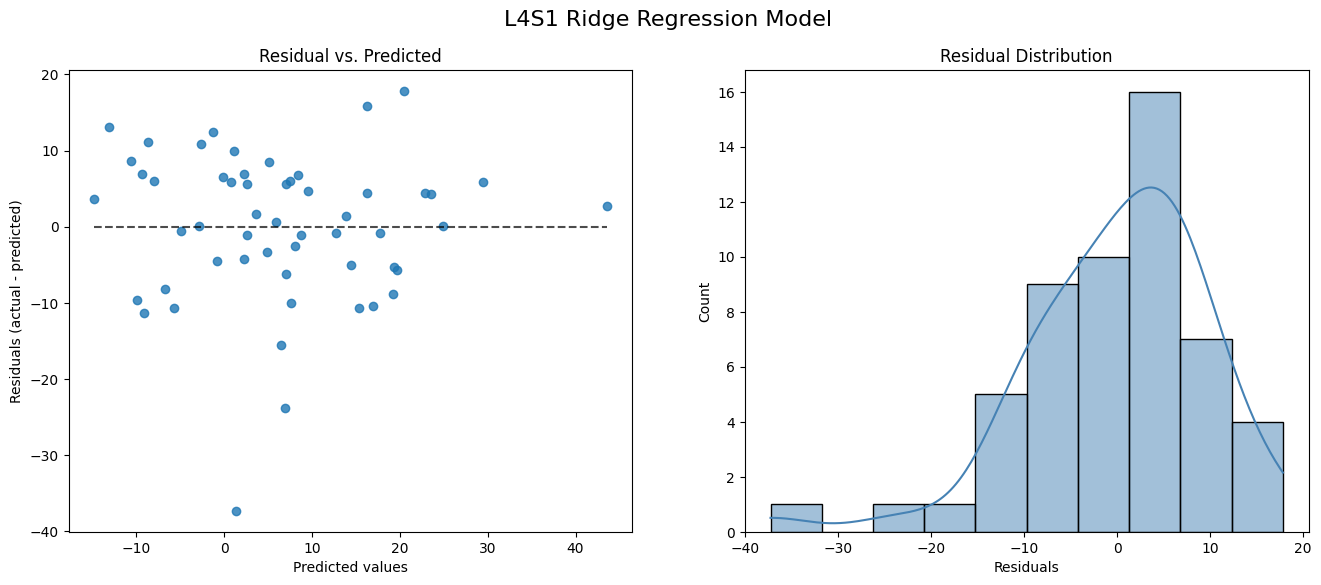

In [67]:
#Visualization of residuals

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("L4S1 Ridge Regression Model", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=L4S1_ridge_ypred, kind="residual_vs_predicted", 
    ax=ax[0])
ax[0].set_title("Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
L4S1_ridge_residuals = y_test - L4S1_ridge_ypred
sns.histplot(x=L4S1_ridge_residuals, kde=True, ax=ax[1], color='steelblue')
ax[1].set_title("Residual Distribution")
ax[1].set_xlabel("Residuals")

plt.show()

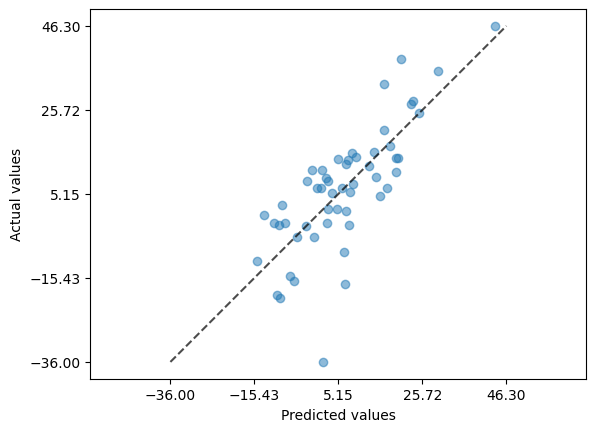

In [68]:
fig, ax = plt.subplots()

PredictionErrorDisplay.from_predictions(
    y_true=y_test, 
    y_pred=L4S1_ridge_ypred, 
    kind="actual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)



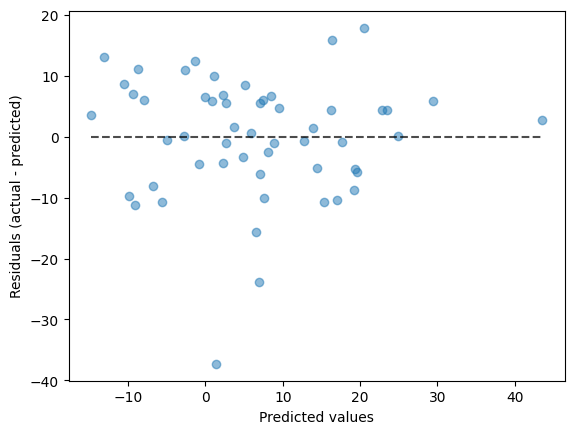

In [69]:
fig, ax = plt.subplots()

PredictionErrorDisplay.from_predictions(
    y_true=y_test, 
    y_pred=L4S1_ridge_ypred, 
    kind="residual_vs_predicted", 
    scatter_kwargs={"alpha": 0.5},
    ax=ax)


#### 3.2 Model 2: LL

In [92]:
df["delta_LL"] = df["LL_postop"] - df["LL_preop"]

df_LL = df.dropna(subset=["delta_LL"])
    
X = df_LL[FEATURES]
y = df_LL["delta_LL"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
#model comparison
LL_rf_pipeline, LL_ypred\
      = train_rf_model(X_train, X_test,y_train,y_test)
print()

LL_xgb_pipeline, LL_xgb_ypred\
      = train_xgboost_model(X_train, X_test,y_train,y_test)

print()

#3 ridge regression - might be good for overfitting and correlated features
LL_ridge_pipeline, LL_ridge_ypred\
      = train_ridge_model(X_train, X_test,y_train,y_test)

#compare using cross validation
compare_models(X,y)

-- Random Forest Model --
R² score: 0.521
RMSE: 9.458
MAE: 7.612
OOB score: 0.574

-- XGBOOST Model --
R² score: 0.481
RMSE: 9.842
MAE: 8.068

-- Ridge Regression Model --
R² score: 0.405
RMSE: 10.54
MAE: 7.829

Cross validation results:

-- RF --
R² score: 0.572
RMSE: 9.625
MAE: 7.36

-- XGBoost --
R² score: 0.549
RMSE: 9.873
MAE: 7.635

-- Ridge --
R² score: 0.514
RMSE: 10.258
MAE: 7.672


In [72]:
#Randomized search cross-validation to finetune Ridge regression parameters

finetuned_ll_model, finetuned_ll_ypred = \
    randomized_search_cv(LL_rf_pipeline, param_distributions,X_train,y_train,X_test,y_test)


--Randomized search results--
Best parameters:
  regressor__n_estimators: 500
  regressor__min_samples_split: 5
  regressor__min_samples_leaf: 2
  regressor__max_features: sqrt
  regressor__max_depth: 8
Best CV R2: 0.518
Test R2: 0.449
Test RMSE: 10.137


In [ ]:
finetuned_ll_model, finetuned_ll_ypred = \
    randomized_search_cv(LL_ridge_pipeline, ridge_param_distributions,X_train,y_train,X_test,y_test)

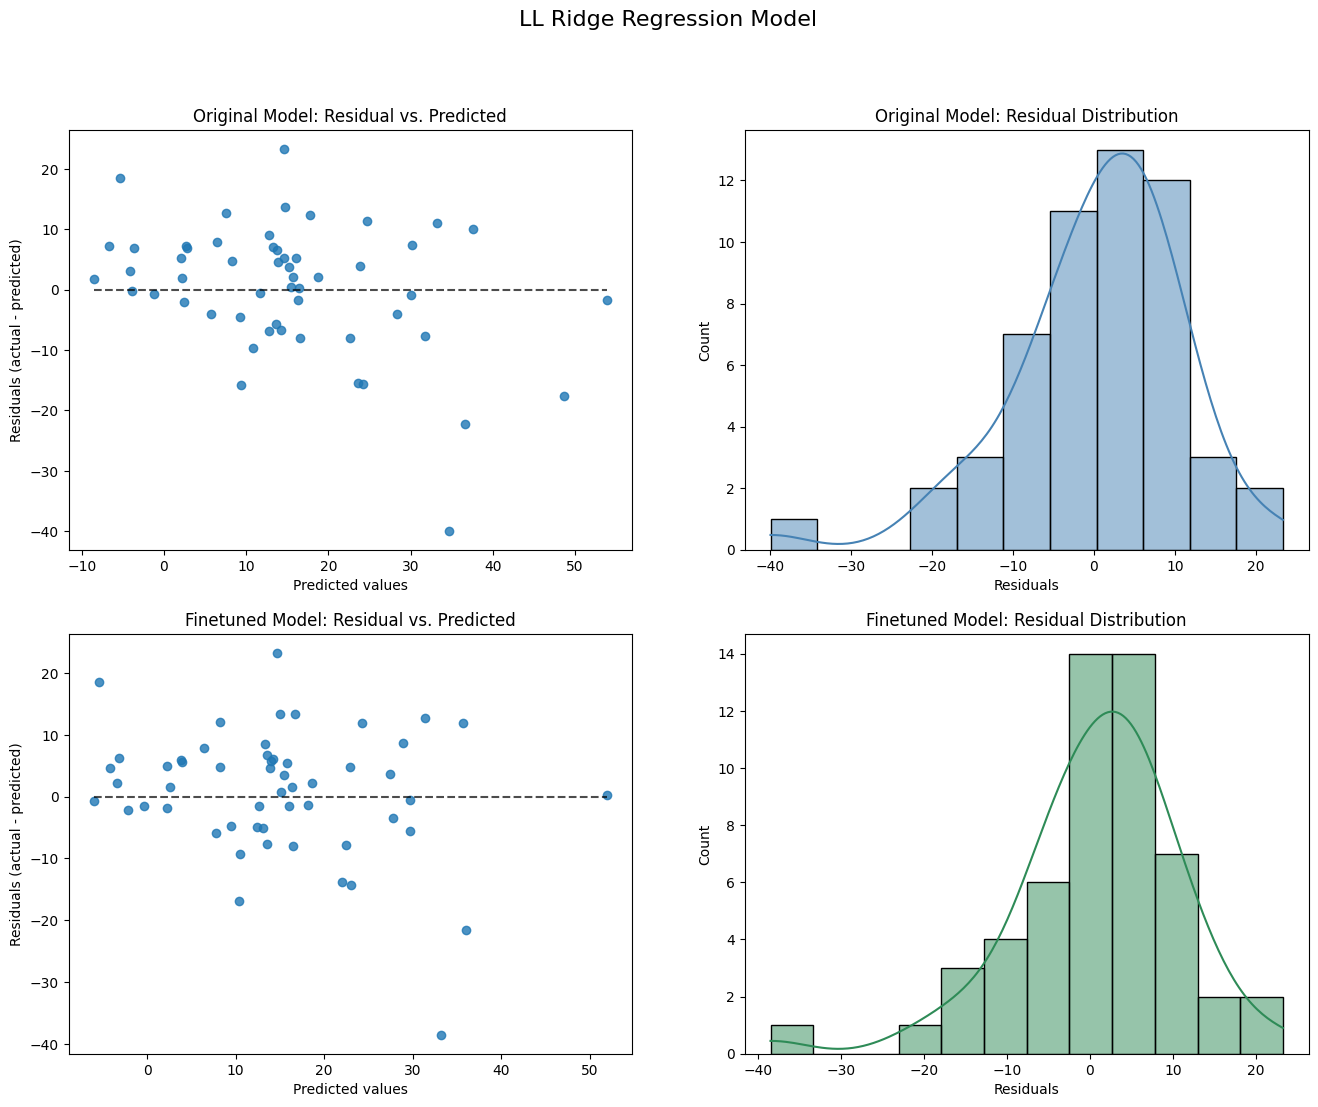

In [24]:
#Visualization of residuals

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("LL Ridge Regression Model", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=LL_ridge_ypred, kind="residual_vs_predicted", 
    ax=ax[0,0])
ax[0,0].set_title("Original Model: Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
ll_ridge_residuals = y_test - LL_ridge_ypred
sns.histplot(x=ll_ridge_residuals, kde=True, ax=ax[0,1], color='steelblue')
ax[0, 1].set_title("Original Model: Residual Distribution")
ax[0, 1].set_xlabel("Residuals")

# Plot 3: Residual vs. Predicted (finetuned model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=finetuned_ll_ypred, kind="residual_vs_predicted", 
    ax=ax[1, 0]
)
ax[1, 0].set_title("Finetuned Model: Residual vs. Predicted")

# Plot 4: Residual Histogram (finetuned model)
LL_ridge_cv_residuals = y_test - finetuned_ll_ypred
sns.histplot(x=LL_ridge_cv_residuals, kde=True, ax=ax[1, 1], color='seagreen')
ax[1, 1].set_title("Finetuned Model: Residual Distribution")
ax[1, 1].set_xlabel("Residuals")


plt.show()

### 3.3 Model 3:T4PA Change

In [94]:
df["delta_T4PA"] = df["T4PA_postop"] - df["T4PA_preop"]

df_T4PA = df.dropna(subset=["delta_T4PA"])
    
X = df_T4PA[FEATURES]
y = df_T4PA["delta_T4PA"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
#model comparison
T4PA_rf_pipeline, T4PA_ypred\
      = train_rf_model(X_train, X_test, y_train, y_test)

print()
T4PA_xgb_pipeline, T4PA_xgb_ypred\
      = train_xgboost_model(X_train, X_test, y_train, y_test)

print()

T4PA_ridge_pipeline, T4PA_ridge_ypred\
      = train_ridge_model(X_train, X_test, y_train, y_test)

#compare using cross validation
compare_models(X,y)

-- Random Forest Model --
R² score: 0.316
RMSE: 8.356
MAE: 5.258
OOB score: 0.602

-- XGBOOST Model --
R² score: 0.269
RMSE: 8.64
MAE: 5.31

-- Ridge Regression Model --
R² score: 0.544
RMSE: 6.822
MAE: 5.331

Cross validation results:

-- RF --
R² score: 0.555
RMSE: 6.398
MAE: 4.66

-- XGBoost --
R² score: 0.497
RMSE: 6.801
MAE: 4.907

-- Ridge --
R² score: 0.582
RMSE: 6.197
MAE: 4.446


In [96]:
#Randomized search cross-validation to finetune Ridge regression parameters

finetuned_T4PA_ridge, finetuned_T4PA_ypred  = \
    randomized_search_cv(T4PA_ridge_pipeline,ridge_param_distributions, X_train,y_train,X_test,y_test)


--Randomized search results--
Best parameters:
  regressor__solver: svd
  regressor__alpha: 100
Best CV R2: 0.625
Test R2: 0.315
Test RMSE: 8.364


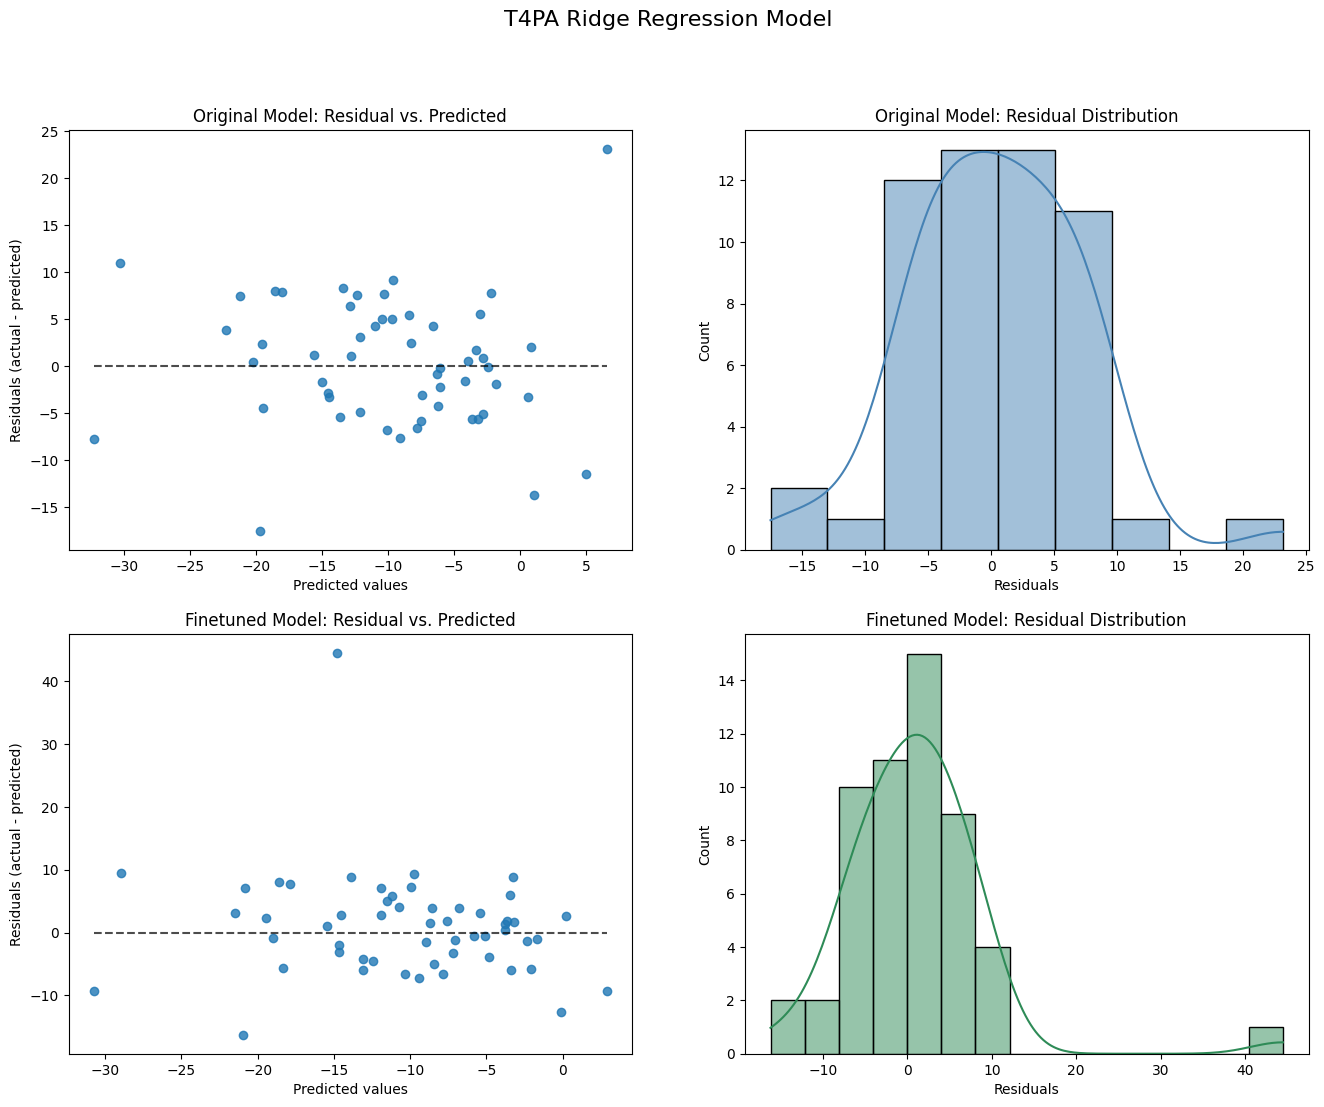

In [28]:
#Visualization of residuals

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("T4PA Ridge Regression Model", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=T4PA_ridge_ypred, kind="residual_vs_predicted", 
    ax=ax[0,0])
ax[0,0].set_title("Original Model: Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
T4PA_ridge_residuals = y_test - T4PA_ridge_ypred
sns.histplot(x=T4PA_ridge_residuals, kde=True, ax=ax[0,1], color='steelblue')
ax[0, 1].set_title("Original Model: Residual Distribution")
ax[0, 1].set_xlabel("Residuals")

# Plot 3: Residual vs. Predicted (finetuned model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=finetuned_T4PA_ypred, kind="residual_vs_predicted", 
    ax=ax[1, 0]
)
ax[1, 0].set_title("Finetuned Model: Residual vs. Predicted")

# Plot 4: Residual Histogram (finetuned model)
T4PA_cv_residuals = y_test - finetuned_T4PA_ypred
sns.histplot(x=T4PA_cv_residuals, kde=True, ax=ax[1, 1], color='seagreen')
ax[1, 1].set_title("Finetuned Model: Residual Distribution")
ax[1, 1].set_xlabel("Residuals")


plt.show()

### 3.4 Model 4:L1PA Change

In [101]:
df["delta_L1PA"] = df["L1PA_postop"] - df["L1PA_preop"]

df_L1PA = df.dropna(subset=["delta_L1PA"])
    
X = df_L1PA[FEATURES]
y = df_L1PA["delta_L1PA"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
#model comparison

L1PA_rf_pipeline, L1PA_ypred\
      = train_rf_model(X_train, X_test, y_train, y_test)

print()

L1PA_xgb_pipeline, L1PA_xgb_ypred\
      = train_xgboost_model(X_train, X_test, y_train, y_test)

print()

L1PA_ridge_pipeline, L1PA_ridge_ypred\
      = train_ridge_model(X_train, X_test,y_train, y_test)

compare_models(X,y)

-- Random Forest Model --
R² score: 0.396
RMSE: 5.115
MAE: 3.749
OOB score: 0.476

-- XGBOOST Model --
R² score: 0.29
RMSE: 5.546
MAE: 4.221

-- Ridge Regression Model --
R² score: 0.502
RMSE: 4.646
MAE: 3.422

Cross validation results:

-- RF --
R² score: 0.463
RMSE: 4.957
MAE: 3.834

-- XGBoost --
R² score: 0.471
RMSE: 4.92
MAE: 3.775

-- Ridge --
R² score: 0.49
RMSE: 4.831
MAE: 3.605


In [103]:
#finetune random forest model
finetuned_L1PA_pipeline, finetuned_L1PA_ypred= \
    randomized_search_cv(L1PA_rf_pipeline, param_distributions,X_train, y_train, X_test, y_test)


--Randomized search results--
Best parameters:
  regressor__n_estimators: 500
  regressor__min_samples_split: 5
  regressor__min_samples_leaf: 4
  regressor__max_features: sqrt
  regressor__max_depth: 20
Best CV R2: 0.468
Test R2: 0.35
Test RMSE: 5.308


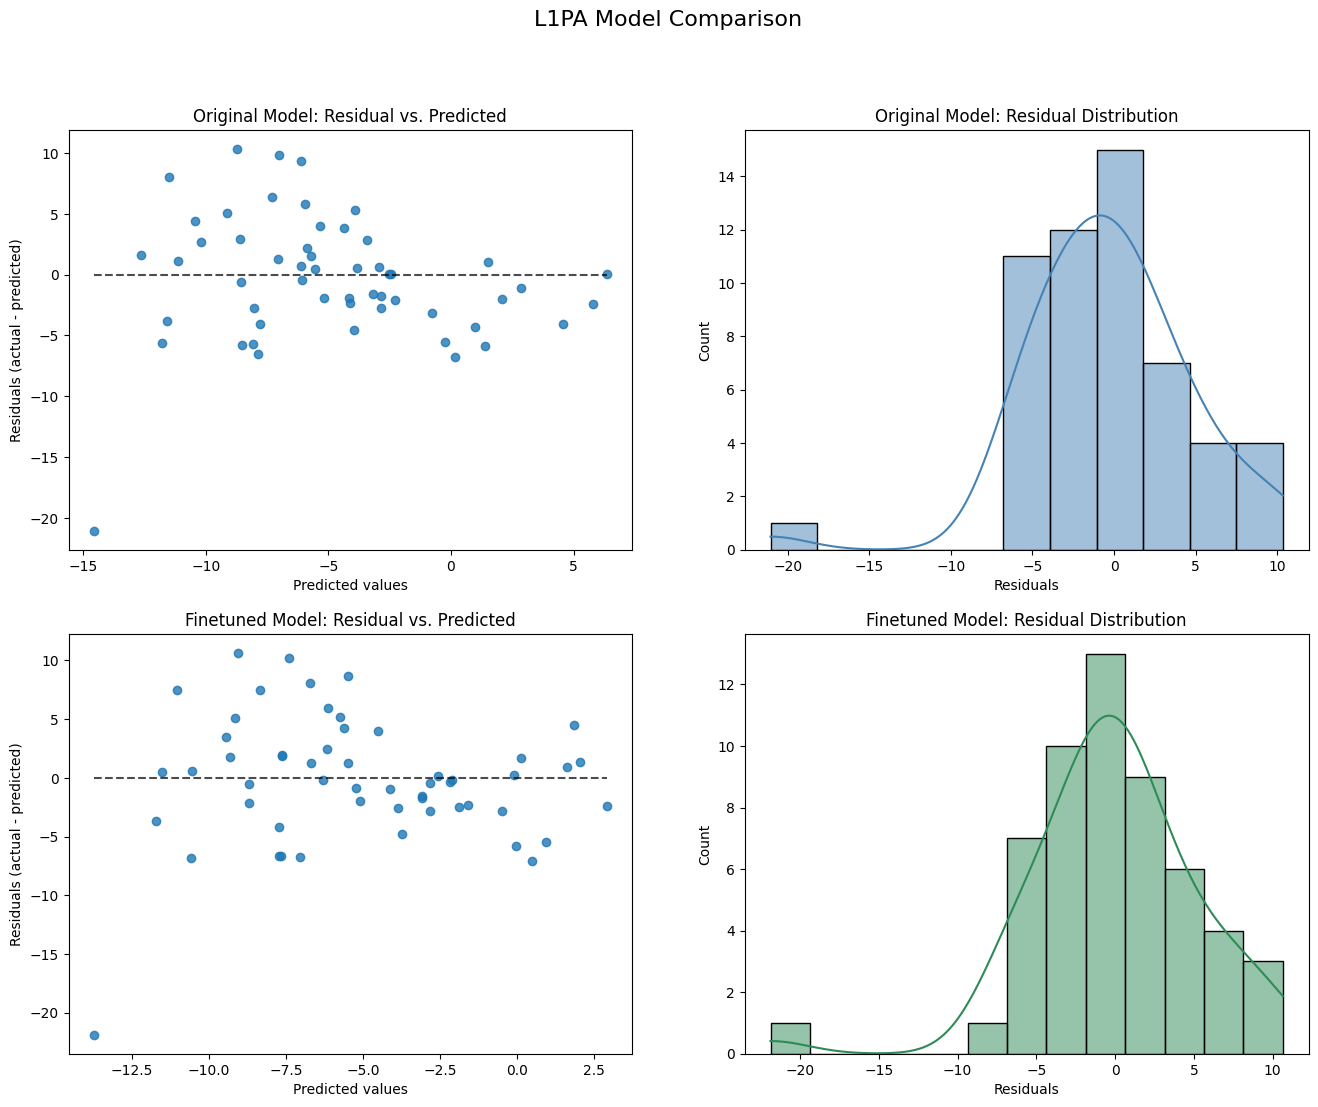

In [32]:
#Visualization of residuals

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("L1PA Model Comparison", fontsize=16)

# Plot 1: Residual vs. Predicted (original model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=L1PA_ypred, kind="residual_vs_predicted", 
    ax=ax[0, 0])
ax[0, 0].set_title("Original Model: Residual vs. Predicted")

# Plot 2:  Residual histogram (original model)
L1PA_residuals = y_test - L1PA_ypred
sns.histplot(x=L1PA_residuals, kde=True, ax=ax[0, 1], color='steelblue')
ax[0, 1].set_title("Original Model: Residual Distribution")
ax[0, 1].set_xlabel("Residuals")

# Plot 3: Residual vs. Predicted (finetuned model)
PredictionErrorDisplay.from_predictions(
    y_true=y_test, y_pred=finetuned_L1PA_ypred, kind="residual_vs_predicted", 
    ax=ax[1, 0]
)
ax[1, 0].set_title("Finetuned Model: Residual vs. Predicted")

# Plot 4: Residual Histogram (finetuned model)
L1PA_cv_residuals = y_test - finetuned_L1PA_ypred
sns.histplot(x=L1PA_cv_residuals, kde=True, ax=ax[1, 1], color='seagreen')
ax[1, 1].set_title("Finetuned Model: Residual Distribution")
ax[1, 1].set_xlabel("Residuals")

plt.show()

#### 3.5 MODEL 5: ODI After 12 months

In [104]:
df["delta_ODI"] = df["ODI_12mo"] - df["ODI_preop"] 

df_ODI = df.dropna(subset=["delta_ODI"]) #many null rows
    
X = df_ODI[FEATURES]
y = df_ODI["delta_ODI"]

#split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
#model comparison

ODI_rf_pipeline, ODI_ypred\
      = train_rf_model(X_train, X_test, y_train, y_test)

print()

ODI_xgb_pipeline, ODI_xgb_ypred\
      = train_xgboost_model(X_train, X_test, y_train, y_test)

print()

ODI_ridge_pipeline, ODI_ridge_ypred\
      = train_ridge_model(X_train, X_test,y_train, y_test)

compare_models(X,y)

-- Random Forest Model --
R² score: 0.474
RMSE: 18.512
MAE: 13.1
OOB score: 0.34

-- XGBOOST Model --
R² score: 0.476
RMSE: 18.482
MAE: 14.853

-- Ridge Regression Model --
R² score: 0.549
RMSE: 17.134
MAE: 14.739

Cross validation results:

-- RF --
R² score: 0.399
RMSE: 17.886
MAE: 13.76

-- XGBoost --
R² score: 0.377
RMSE: 18.212
MAE: 14.253

-- Ridge --
R² score: 0.43
RMSE: 17.42
MAE: 13.904


In [110]:
#finetune ridge regression model
finetuned_ODI_pipeline, finetuned_ODI_ypred= \
    randomized_search_cv(ODI_ridge_pipeline, ridge_param_distributions,X_train, y_train, X_test, y_test)


--Randomized search results--
Best parameters:
  regressor__solver: svd
  regressor__alpha: 10
Best CV R2: 0.29
Test R2: 0.566
Test RMSE: 16.812


### 4. Export Model

In [ ]:
#build final model for deployment - L4S1 ridge regression 
X = df_L4S1[FEATURES]
y = df_L4S1["delta_L4S1"]

final_L4S1_pipeline = Pipeline([
        ("preprocessor", clone(ridge_preprocessor)),
        ("regressor", Ridge(alpha=1))
    ])

final_L4S1_pipeline.fit(X,y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [ ]:
#build final model for deployment - LL random forest
X = df_LL[FEATURES]
y = df_LL["delta_LL"]

#change to random forest model 
final_LL_pipeline = Pipeline([
    ("preprocessor", clone(preprocessor)), 
    ("regressor", RandomForestRegressor(n_estimators=300, 
                                        random_state=42,
                                        max_depth=8,
                                        min_samples_leaf=5,
                                        oob_score=True))])
final_LL_pipeline.fit(X,y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [97]:
#build final model for deployment - T4PA ridge regression
X = df_T4PA[FEATURES]
y = df_T4PA["delta_T4PA"]

final_T4PA_pipeline = Pipeline([
        ("preprocessor", clone(ridge_preprocessor)),
        ("regressor", Ridge(alpha=1))
    ])

final_T4PA_pipeline.fit(X,y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [ ]:
#build final model for deployment - L1PA ridge regression
X = df_L1PA[FEATURES]
y = df_L1PA["delta_L1PA"]

final_L1PA_pipeline = Pipeline([
        ("preprocessor", clone(ridge_preprocessor)),
        ("regressor", Ridge(alpha=1))
    ])

final_L1PA_pipeline.fit(X,y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [111]:
#build final model for deployment - ODI ridge regression
X = df_ODI[FEATURES]
y = df_ODI["delta_ODI"]

final_ODI_pipeline = Pipeline([
        ("preprocessor", clone(ridge_preprocessor)),
        ("regressor", Ridge(alpha=1))
    ])

final_ODI_pipeline.fit(X,y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

In [ ]:
import joblib, sklearn
from src import config

# L4S1 model
L4S1_dir = config.ARTIFACTS_DIR / "L4S1"
L4S1_dir.mkdir(parents=True, exist_ok=True)

bundle_L4S1 = {
    "pipe": L4S1_ridge_pipeline,
    "features": FEATURES,
    "target": "delta_L4S1",
    "sklearn_version": sklearn.__version__,
    "model_name": "L4S1_ridge_reg",
}

out_path = L4S1_dir / "L4S1_ridge_reg.joblib"
joblib.dump(bundle_L4S1, out_path)
print("Saved:", out_path)

# LL model
LL_dir = config.ARTIFACTS_DIR / "LL"
LL_dir.mkdir(parents=True, exist_ok=True)

bundle_LL = {
    "pipe": LL_ridge_pipeline,
    "features": FEATURES,
    "target": "delta_LL",
    "sklearn_version": sklearn.__version__,
    "model_name": "LL_ridge_reg",
}

out_path = LL_dir / "LL_ridge_reg.joblib"
joblib.dump(bundle_LL, out_path)
print("Saved:", out_path)

# T4PA model
T4PA_dir = config.ARTIFACTS_DIR / "T4PA"
T4PA_dir.mkdir(parents=True, exist_ok=True)

bundle_T4PA = {
    "pipe": T4PA_ridge_pipeline,
    "features": FEATURES,
    "target": "delta_T4PA",
    "sklearn_version": sklearn.__version__,
    "model_name": "T4PA_ridge_reg",
}

out_path = T4PA_dir / "T4PA_ridge_reg.joblib"
joblib.dump(bundle_T4PA, out_path)
print("Saved:", out_path)

# L1PA model
L1PA_dir = config.ARTIFACTS_DIR / "L1PA"
L1PA_dir.mkdir(parents=True, exist_ok=True)

bundle_L1PA = {
    "pipe": finetuned_L1PA_pipeline,
    "features": FEATURES,
    "target": "delta_L1PA",
    "sklearn_version": sklearn.__version__,
    "model_name": "L1PA_rf_reg",
}

out_path = L1PA_dir / "L1PA_rf_reg.joblib"
joblib.dump(bundle_L1PA, out_path)
print("Saved:", out_path)

# ODI model
ODI_dir = config.ARTIFACTS_DIR / "ODI"
ODI_dir.mkdir(parents=True, exist_ok=True)

bundle_ODI = {
    "pipe": ODI_ridge_pipeline,
    "features": FEATURES,
    "target": "delta_ODI",
    "sklearn_version": sklearn.__version__,
    "model_name": "ODI_ridge_reg",
}

out_path = ODI_dir / "ODI_ridge_reg.joblib"
joblib.dump(bundle_ODI, out_path)
print("Saved:", out_path)